In [1]:
import numpy as np
from scipy import io
from scipy import sparse
from scipy.sparse import csgraph
from scipy import signal
from scipy import linalg
from matplotlib import pyplot as plt
from matplotlib import collections
from sklearn.cluster import KMeans
import mpl_toolkits.mplot3d.art3d as art3d
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_palette('husl')

# Load data

In [3]:
minn = io.loadmat('../data/minnesota.mat')
Aroads = minn['Problem'][0][0][2]
xy = minn['Problem'][0][0][8][0][0][0]

numcomp, components = csgraph.connected_components(Aroads)
compsize = np.max(np.bincount(components))
biggestcomp = np.argmax(np.bincount(components))
in_component = np.where(components == biggestcomp)[0]

Aroads = Aroads.todense()
Aroads = Aroads[in_component][:, in_component]
Aroads = sparse.csc_matrix(Aroads)

xy = xy[in_component]

links = np.where(Aroads.todense())
startcoords = xy[links[0]]
endcoords = xy[links[1]]
lines = [[tuple(x), tuple(y)] for x, y in zip(startcoords, endcoords)]

# Use a Ricker wavelet

In [4]:
tau = 11
hat = signal.ricker(1000, 100)[500:]

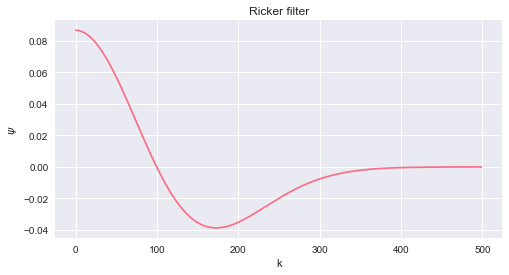

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(hat)
plt.xlabel('k')
plt.ylabel(r'$\psi$')
plt.title('Ricker filter')
plt.savefig('../img/wavelet_filter_0.pdf', bbox_inches='tight')

# Implement wavelet transform

The wavelet function $\Psi$ at scale k and center vertex i is defined by:

\begin{equation}
 \Psi_{k,i}^{CKWT} (j) = \frac{a_{k, \tau}}{|\partial N_{(i, \tau)}|}, \forall j \in \partial N(i, \tau)
\end{equation}

Where $\partial N_{(i, \tau)}$ is the set of all vertices $j \in N$ such that the geodesic distance between $i$ and $j$ is $\tau$. $a_{k, \tau}$ is a set of coefficients that approximate the continuous wavelet function.

In [6]:
def ckwt_wavelet(A, tau, h):
    '''
    A : adjacency matrix
    tau: scale factor
    h: continuous wavelet filter
    '''
    
    # Construct graph wavelet filter, W
    W = np.zeros(A.shape).astype(float)
    # Generate geodesic distances
    spath = csgraph.shortest_path(A, directed=False, unweighted=True).astype(int)
    # Resample filter
    if not (h.size % tau):
        hm = h.reshape(tau, -1).mean(axis=1)
    else:
        hm = h[:-(h.size % tau)].reshape(tau, -1).mean(axis=1)
        
    for i in range(W.shape[0]):
        # N: histogram of distances from i
        # N_t: Number of vertices within k hops of i for all k < tau
        N = np.bincount(spath[i, :])
        N_t = np.where(spath[i, :] < tau, N[spath[i, :]], i)
        mask = (spath[i, :] < tau)
        # a : wavelet coefficients
        a = np.zeros_like(spath[i, :]).astype(float)
        a[mask] = hm[spath[i, :][mask]] / N_t[mask].astype(float)
        W[:, i] = a
    return W

In [7]:
# Generate wavelet transform for the roads graph
W = ckwt_wavelet(Aroads, tau, hat)

In [8]:
# Generate localized piecewise graph signal
L = csgraph.laplacian(Aroads).todense()
l, u = np.linalg.eigh(L)

# Signal g with strong discontinuity
kmeans = KMeans(n_clusters=3, random_state=1).fit(u[:, :3])
g = np.where(kmeans.labels_ == 0, 1, -1) + 0.1*np.random.randn(Aroads.shape[0])

# Fourier transform of g
ghat = np.asarray(u.T @ g)

# Plot filtering result with a scaling factor of 10

In [9]:
# gg is the result of applying the wavelet transform to the signal
gg = W.T @ g

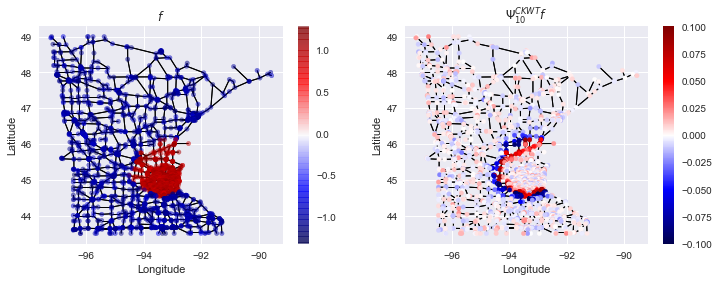

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

lc = collections.LineCollection(lines, linewidths=1, colors='k')

li = ax[0].add_collection(lc)
sc = ax[0].scatter(xy[:, 0], xy[:, 1], s=20, c=g, alpha=0.5,
                zorder=2, cmap='seismic', vmin=g.min(), vmax=g.max())
plt.colorbar(sc, ax=ax[0])

lc = collections.LineCollection(lines, linewidths=1, colors='k')

li = ax[1].add_collection(lc)
sc = ax[1].scatter(xy[:, 0], xy[:, 1], s=20, c=gg, alpha=1,
                zorder=2, cmap='seismic', vmin=-0.1, vmax=0.1)
plt.colorbar(sc, ax=ax[1])

ax[0].set_title(r'$f$')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

ax[1].set_title(r'$\Psi_{10}^{CKWT} f$')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
plt.savefig('../img/wavelet_filter_1.pdf', bbox_inches='tight')

# Plot filtering result with a scaling factor of 4

In [11]:
tau = 5
W = ckwt_wavelet(Aroads, tau, hat)
gg = W.T @ g

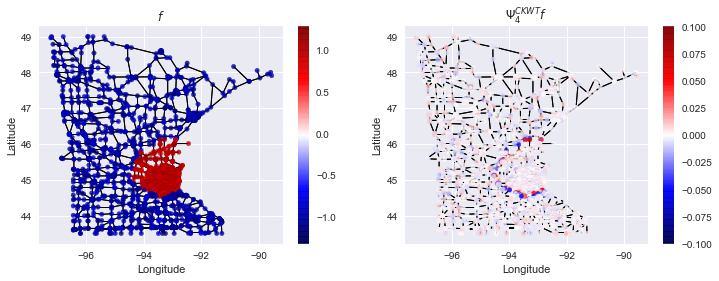

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

lc = collections.LineCollection(lines, linewidths=1, colors='k')

li = ax[0].add_collection(lc)
sc = ax[0].scatter(xy[:, 0], xy[:, 1], s=20, c=g, alpha=0.8,
                zorder=2, cmap='seismic', vmin=g.min(), vmax=g.max())
plt.colorbar(sc, ax=ax[0])

lc = collections.LineCollection(lines, linewidths=1, colors='k')

li = ax[1].add_collection(lc)
sc = ax[1].scatter(xy[:, 0], xy[:, 1], s=20, c=gg, alpha=0.8,
                zorder=2, cmap='seismic', vmin=-0.1, vmax=0.1)
plt.colorbar(sc, ax=ax[1])

ax[0].set_title(r'$f$')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

ax[1].set_title(r'$\Psi_{4}^{CKWT} f$')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
plt.savefig('../img/wavelet_filter_2.pdf', bbox_inches='tight')

# Compute spatial and spectral spreads of signal

#### Spatial spread of a signal around a vertex

The spatial spread of the signal $f$ around a center vertex $i$ is given by:

\begin{equation}
\Delta_{G, i}^2(f) = \frac{1}{||f||_2^2} \sum_{j \in V} [d_G(i,j)]^2 [f(j)]^2
\end{equation}

Where $d_G(i,j)$ is the geodesic (shortest path) distance between vertices i and j.

#### Spatial spread of a graph signal

The spatial spread of the graph signal is the minimum spatial spread across the vertices:

\begin{equation}
\Delta_{G}^2(f) = \min_{i \in V} \{ \Delta_{G, i}^2(f) \}
\end{equation}

#### Spectral spread of a graph signal

The spectral spread of the graph signal is given by:

\begin{equation}
\Delta_{\sigma}^2(f) = \min_{i \in V} \bigg\{ \frac{1}{||f||_2^2} \sum_{\lambda \in \sigma(L)} [\sqrt{\lambda} - \sqrt{\mu}]^2 [\hat{f}(\lambda)]^2 \bigg\}
\end{equation}

In [13]:
# Compute geodesic distances for all vertices
spath = csgraph.shortest_path(Aroads, directed=False, unweighted=True).astype(int)

In [14]:
def spatial_spreads(g, spath=None, A=None):
    '''
    g : input signal
    spath : pairwise geodesic distances (distance matrix of A)
    A : adjacency matrix
    '''
    if spath is None:
        spath = csgraph.shortest_path(A, directed=False, unweighted=True).astype(int)
    return ((spath**2 * g**2).T).sum(axis=0) / np.linalg.norm(g)**2

def spectral_spreads(ghat, l, mu=None):
    '''
    ghat : input kernel
    l : eigenvalues of the laplacian
    mu : initial estimates for mean
    '''
    if mu is None:
        mu = np.linspace(0, l.max(), len(l))
    return ((ghat.reshape(ghat.size, 1)**2 * (np.sqrt((l.reshape(l.size, 1))) 
             - np.sqrt(mu.reshape(1, mu.size)))**2).sum(axis=0) / 
            np.linalg.norm(ghat)**2)

In [15]:
# Compute the spatial spreads for each vertex, i
spatial_spreads_g = spatial_spreads(g, spath)
# Compute graph spatial spread
spatial_ix_min = np.argmin(spatial_spreads_g)
graph_spatial_spread = spatial_spreads_g[spatial_ix_min]
print("Min vertex: ", spatial_ix_min)
print("Graph spatial spread: ", graph_spatial_spread)

Min vertex:  1353
Graph spatial spread:  799.739558509


In [16]:
# Compute the spectral spreads for each candidate mu
mu = np.linspace(0, l.max(), 10000)
spectral_spreads_ghat = spectral_spreads(ghat, l, mu)
# Compute the graph spectral spread
spectral_ix_min = np.argmin(spectral_spreads_ghat)
graph_spectral_spread = spectral_spreads_ghat[spectral_ix_min]
print("Min lambda: ", spectral_ix_min)
print("Graph spectral spread: ", graph_spectral_spread)

Min lambda:  16
Graph spectral spread:  0.0636308311967


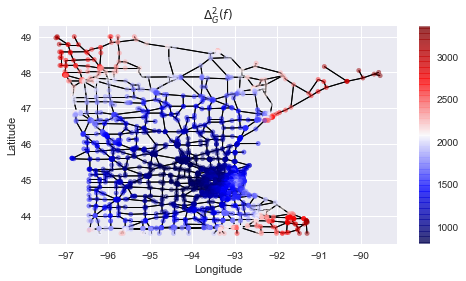

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))

lc = collections.LineCollection(lines, linewidths=1, colors='k')

li = ax.add_collection(lc)
sc = ax.scatter(xy[:, 0], xy[:, 1], s=20, c=spatial_spreads_g, alpha=0.5,
                zorder=2, cmap='seismic', vmin=spatial_spreads_g.min(),
                   vmax=spatial_spreads_g.max())
plt.colorbar(sc, ax=ax)

lc = collections.LineCollection(lines, linewidths=1, colors='k')

ax.set_title(r'$\Delta^2_G(f)$')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.savefig('../img/wavelet_filter_3.pdf', bbox_inches='tight')

# Compute spatial spread of wavelet transform

Compute the spatial spread of a transform $\Psi_k$ by taking an average over all scale k wavelet functions of the spatial spreads around each center vertex i.

In [18]:
# Spatial spreads of wavelet transform when k=4
# Note that because it will always be minimum at i, we can simplify the calculation
spatial_spreads_w = (spath**2 * W**2).sum(axis=0) / np.sum(W**2, axis=0)

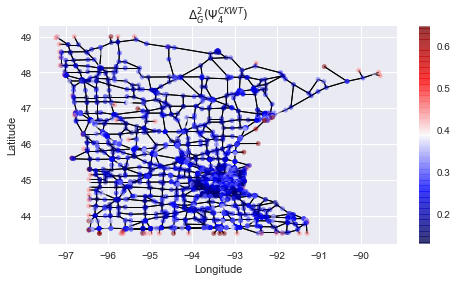

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))

lc = collections.LineCollection(lines, linewidths=1, colors='k')

li = ax.add_collection(lc)
sc = ax.scatter(xy[:, 0], xy[:, 1], s=20, c=spatial_spreads_w, alpha=0.5,
                zorder=2, cmap='seismic', vmin=spatial_spreads_w.min(),
                   vmax=spatial_spreads_w.max())
plt.colorbar(sc, ax=ax)

lc = collections.LineCollection(lines, linewidths=1, colors='k')

ax.set_title(r'$\Delta^2_G(\Psi_{4}^{CKWT})$')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.savefig('../img/wavelet_filter_4.pdf', bbox_inches='tight')

# Compute spatial and spectral spreads of wavelet transform at multiple scales

In [20]:
# Compute spatial spreads for varying k
all_spatial_spreads = []
k_range = np.arange(8, 30)

for tau in k_range:
    W = ckwt_wavelet(Aroads, tau, hat)
    spatial_spreads_w = (spath**2 * W**2).sum(axis=0) / np.sum(W**2, axis=0)
    mean_spatial_spread = spatial_spreads_w.mean()
    all_spatial_spreads.append(mean_spatial_spread)
    
all_spatial_spreads = np.asarray(all_spatial_spreads)

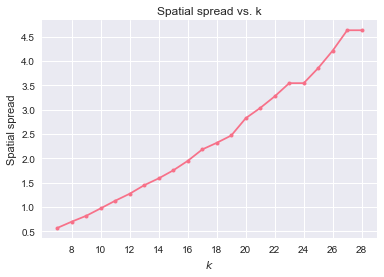

In [21]:
plt.plot(k_range - 1, all_spatial_spreads, marker='o', markersize=4)
plt.xlabel(r'$k$')
plt.ylabel('Spatial spread')
plt.title('Spatial spread vs. k')
xt = plt.xticks(np.arange(k_range.min(), k_range.max(), 2))
plt.savefig('../img/wavelet_filter_5.pdf', bbox_inches='tight')

In [22]:
# Compute spectral spreads for varying k
all_spectral_spreads = []
k_range = np.arange(8, 30)

for tau in k_range:
    W = ckwt_wavelet(Aroads, tau, hat)
    What = np.asarray((np.conj(u).T @ W))
    Psihat = (What**2).sum(axis=1) / len(What)
    spectral_spreads_what = spectral_spreads(Psihat, l, mu)
    all_spectral_spreads.append(spectral_spreads_what.min())
    
all_spectral_spreads = np.asarray(all_spectral_spreads)

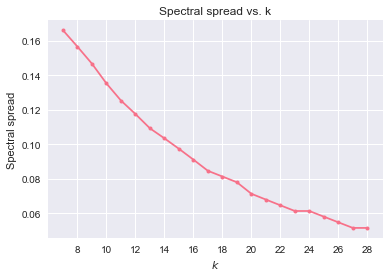

In [23]:
plt.plot(k_range - 1, all_spectral_spreads, marker='o', markersize=4)
plt.xlabel(r'$k$')
plt.ylabel('Spectral spread')
plt.title('Spectral spread vs. k')
xt = plt.xticks(np.arange(k_range.min(), k_range.max(), 2))
plt.savefig('../img/wavelet_filter_6.pdf', bbox_inches='tight')

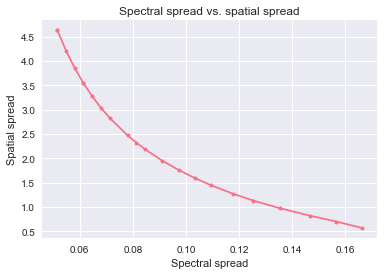

In [24]:
plt.plot(all_spectral_spreads, all_spatial_spreads, marker='o', markersize=4)
plt.xlabel(r'Spectral spread')
plt.ylabel('Spatial spread')
plt.title('Spectral spread vs. spatial spread')
plt.savefig('../img/wavelet_filter_7.pdf', bbox_inches='tight')